In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import poissonImg,poisson

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5,1,'img_dst.shape = (400, 300, 3)')

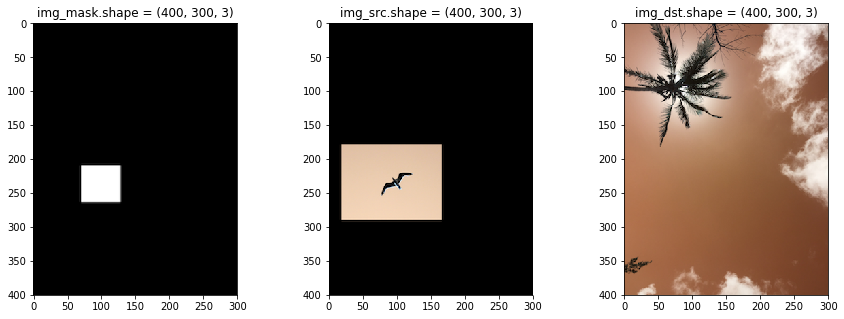

In [26]:
# read images
img_mask = cv2.imread('mask.png')
img_src = cv2.imread('source.png')
img_dst = cv2.imread('target.png')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_mask)
plt.title('img_mask.shape = %s' % (img_mask.shape,))
plt.subplot(1,3,2)
plt.imshow(img_src)
plt.title('img_src.shape = %s' % (img_src.shape,))
plt.subplot(1,3,3)
plt.imshow(img_dst)
plt.title('img_dst.shape = %s' % (img_dst.shape,))

In [29]:
img_clone = np.zeros(img_dst.shape)
for k in range(3):
    #img_clone[:,:,k] = poissonImg.poisson_clone(img_src[:,:,k],img_dst[:,:,k],img_mask[:,:,0])
    img_clone[:,:,k] = poisson.process(img_src[:,:,k],img_dst[:,:,k],img_mask[:,:,0])

Text(0.5,1,'img_dst.shape = (400, 300, 3)')

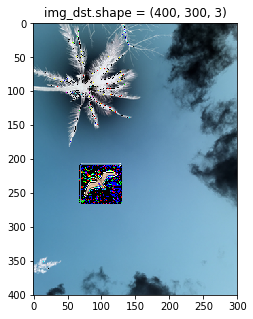

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(img_clone)
plt.title('img_dst.shape = %s' % (img_dst.shape,))